In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import hilbert

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file path in Google Drive
drive_path = "/content/drive/My Drive/TimeSeries/historical_data.csv"

# Load dataset
df = pd.read_csv(drive_path, parse_dates=['Date'], index_col='Date')

# Ensure the data is sorted by date
df = df.sort_index()

# Select the 'Close' column
data = df[['Close']].copy()

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0088 - val_loss: 0.0012
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 2.1521e-04 - val_loss: 0.0011
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 2.0094e-04 - val_loss: 0.0022
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.0240e-04 - val_loss: 9.7492e-04
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.0289e-04 - val_loss: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.7146e-04 - val_loss: 7.5657e-04
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.8882e-04 - val_loss: 7.4094e-04
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5486e-04 - val_loss: 7.1418e-04
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.6080e-04 - val_loss: 6.4891e-04
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.7602e-04 - val_loss: 5.5852e-04
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.1695

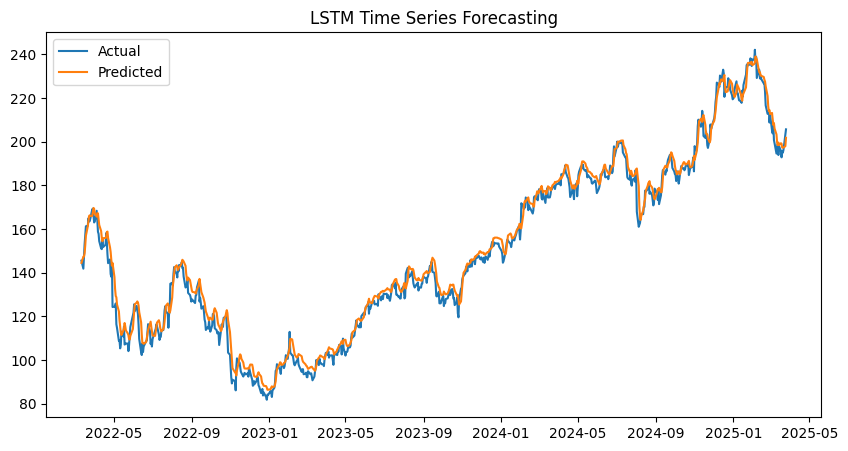

In [2]:
# Normalize data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(data_scaled, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted')
plt.legend()
plt.title('LSTM Time Series Forecasting')
plt.show()